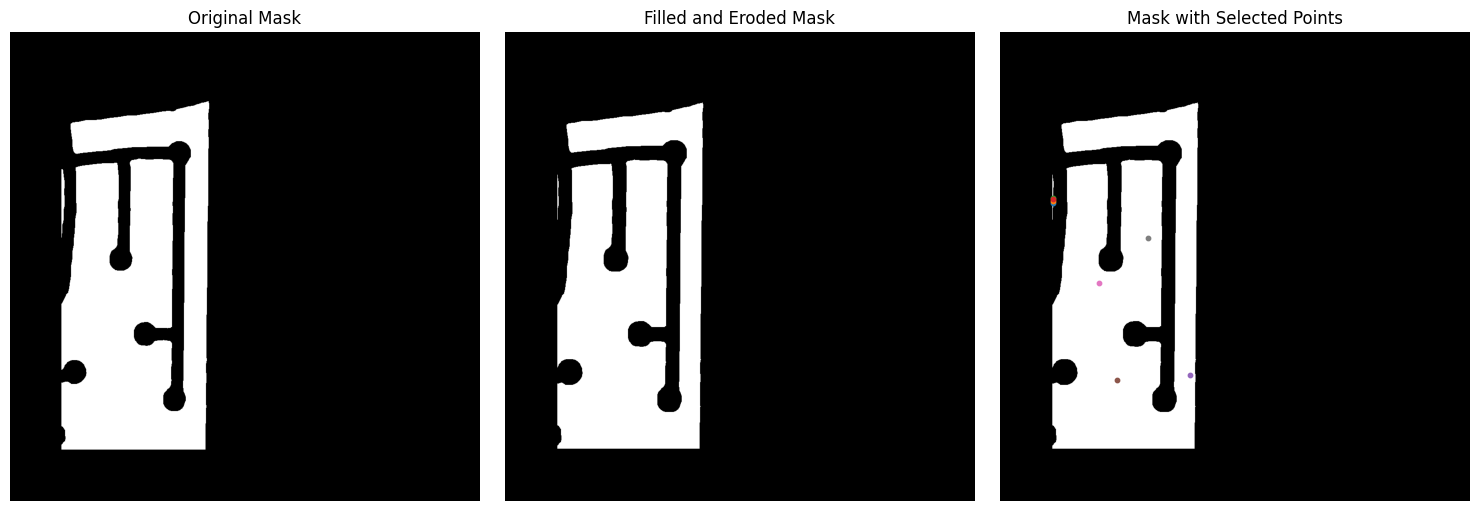

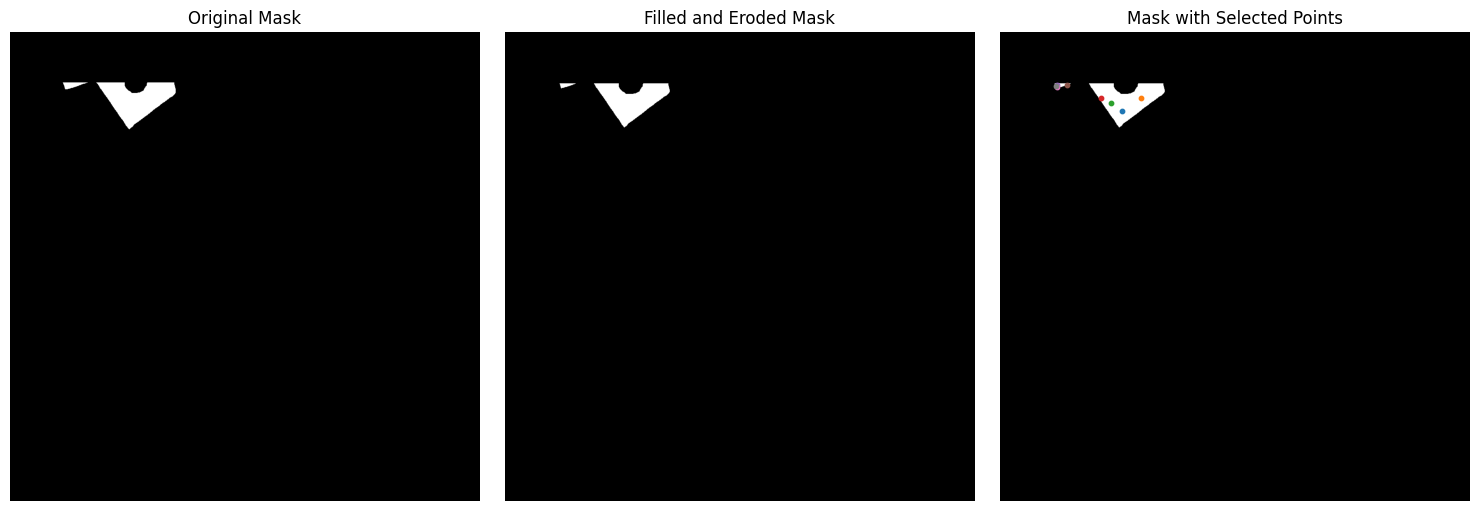

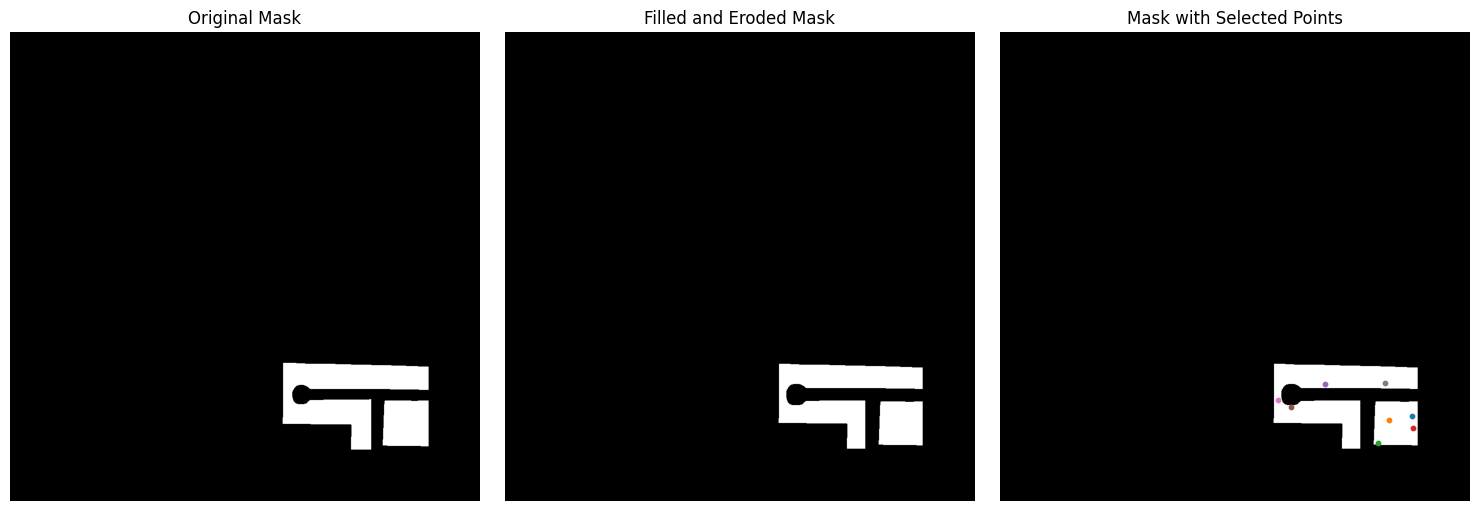

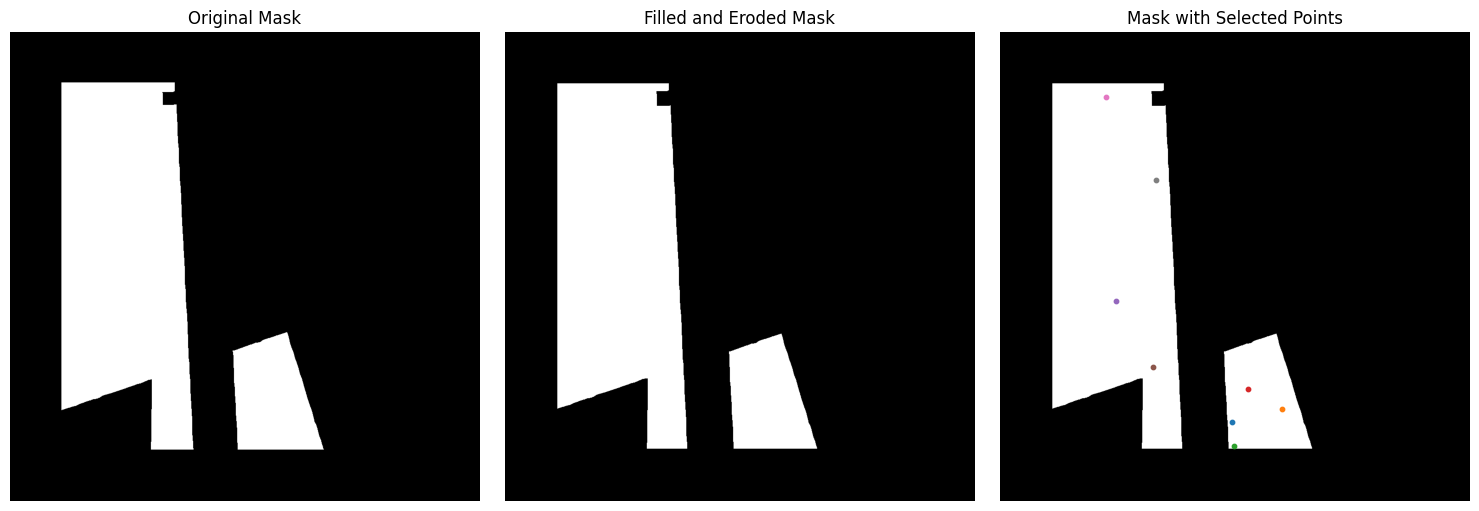

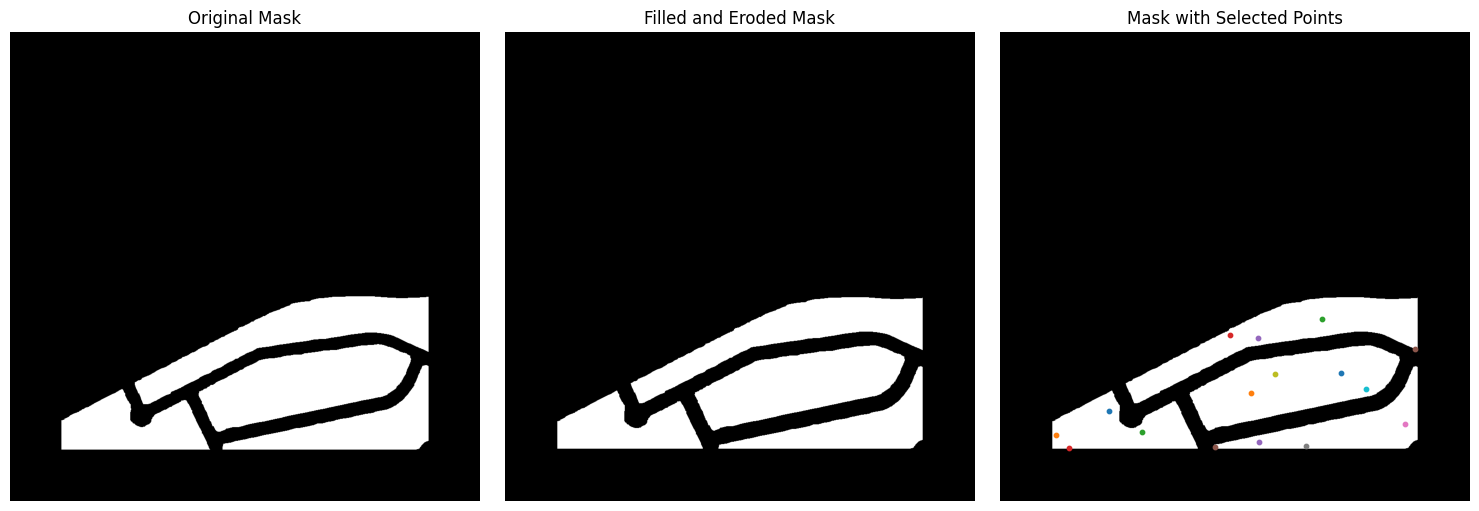

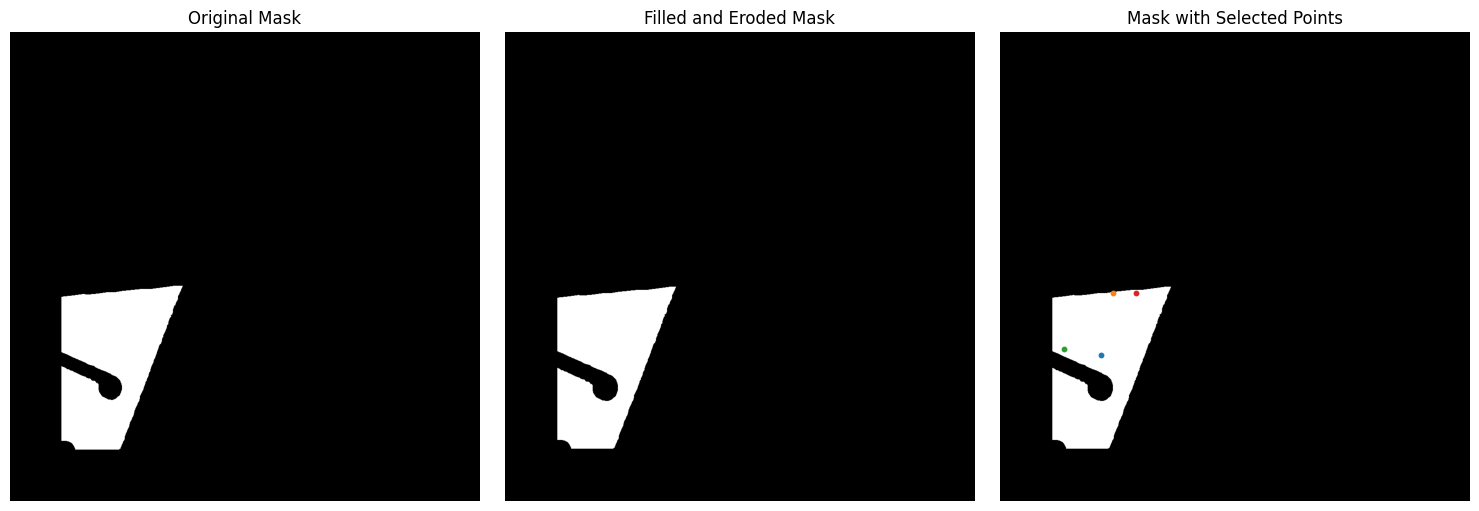

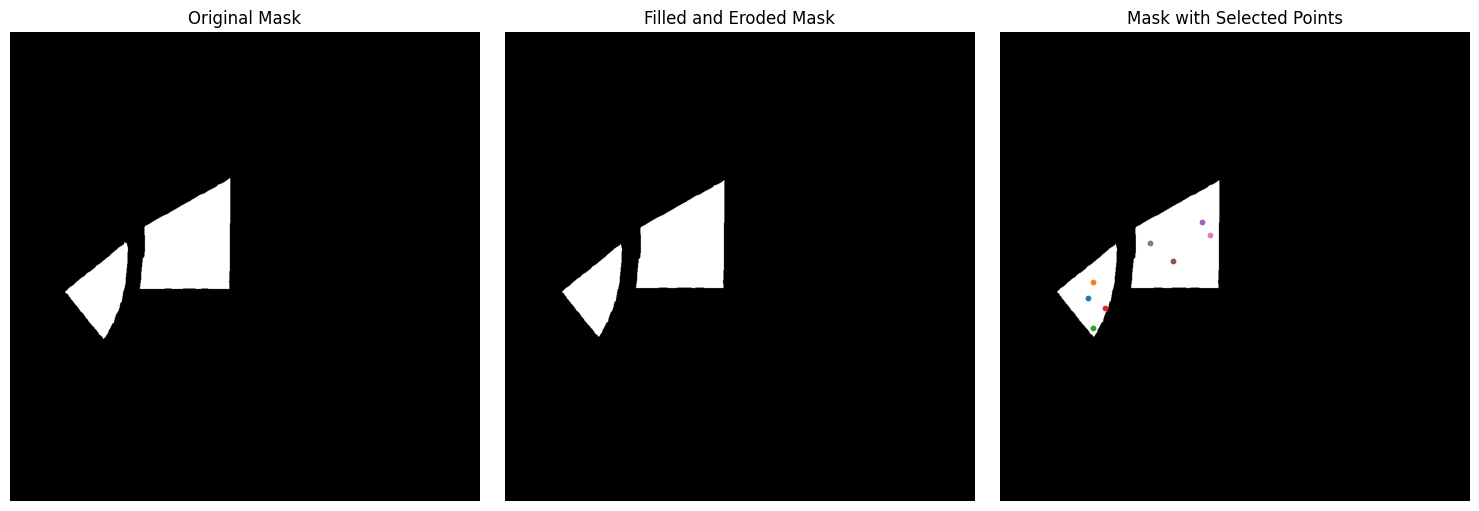

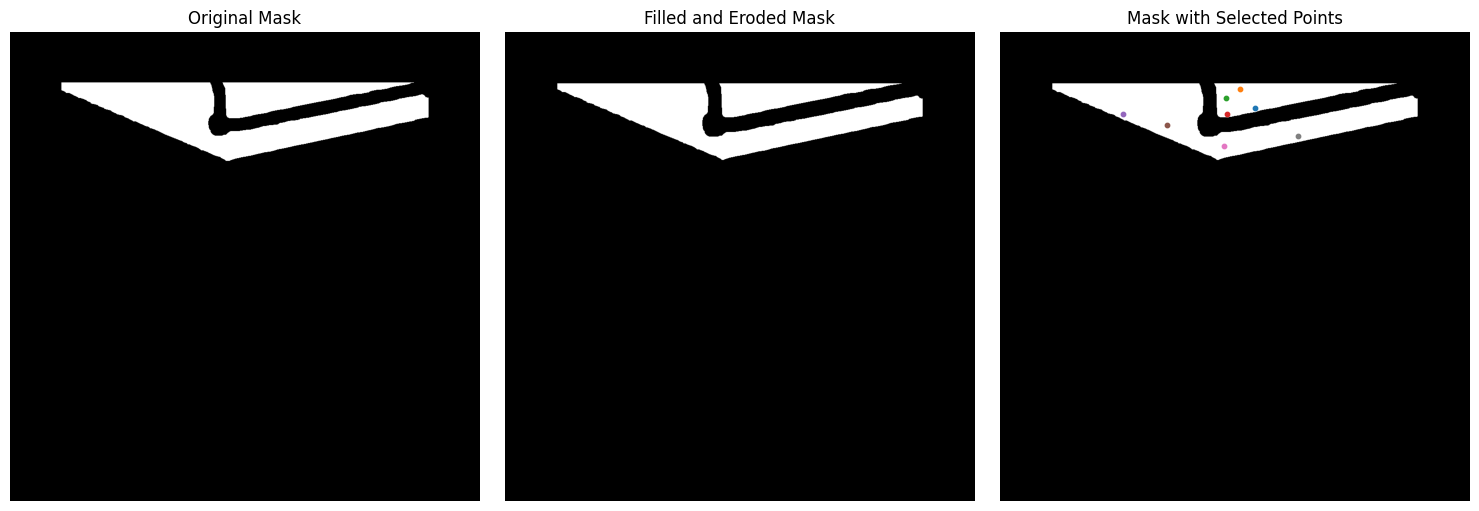

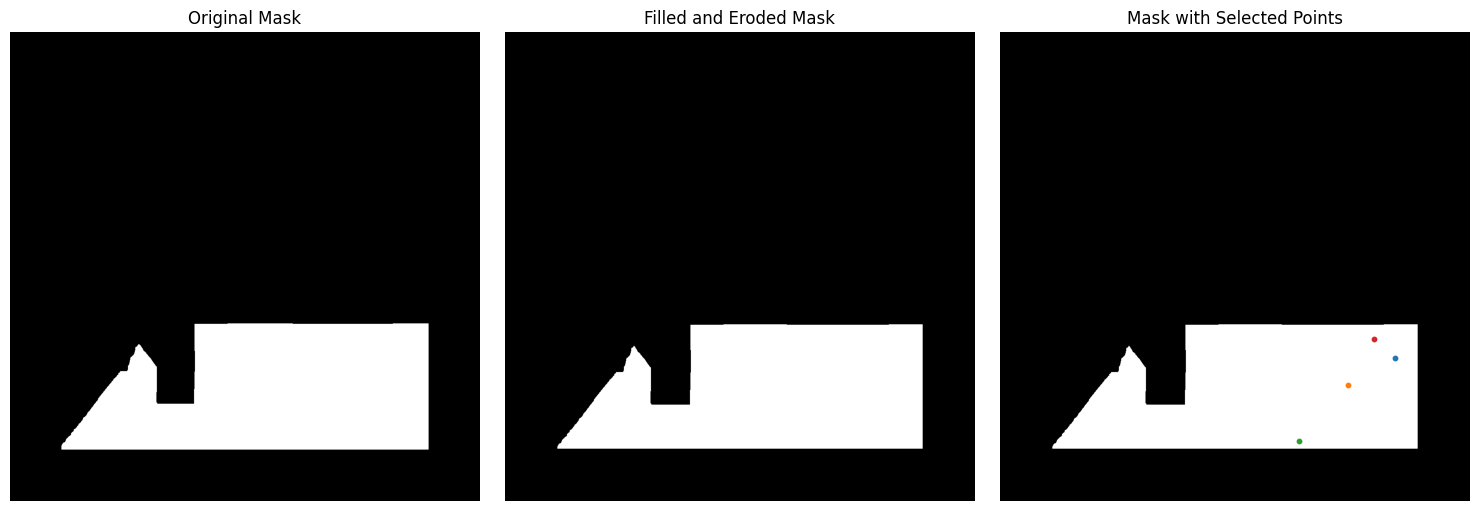

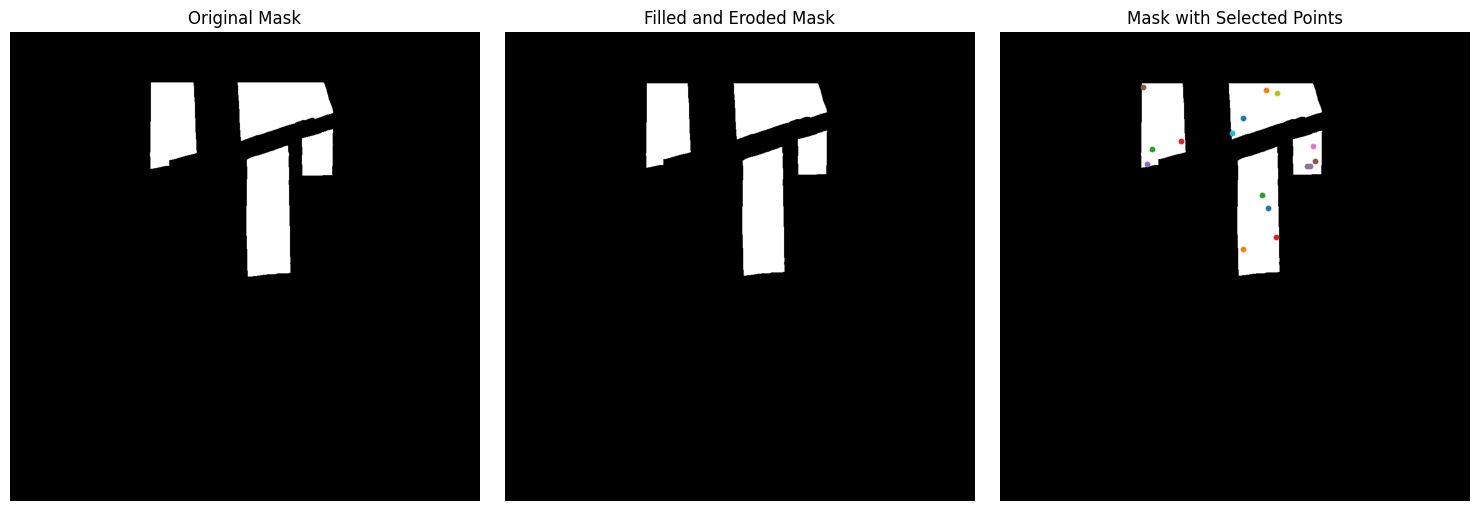

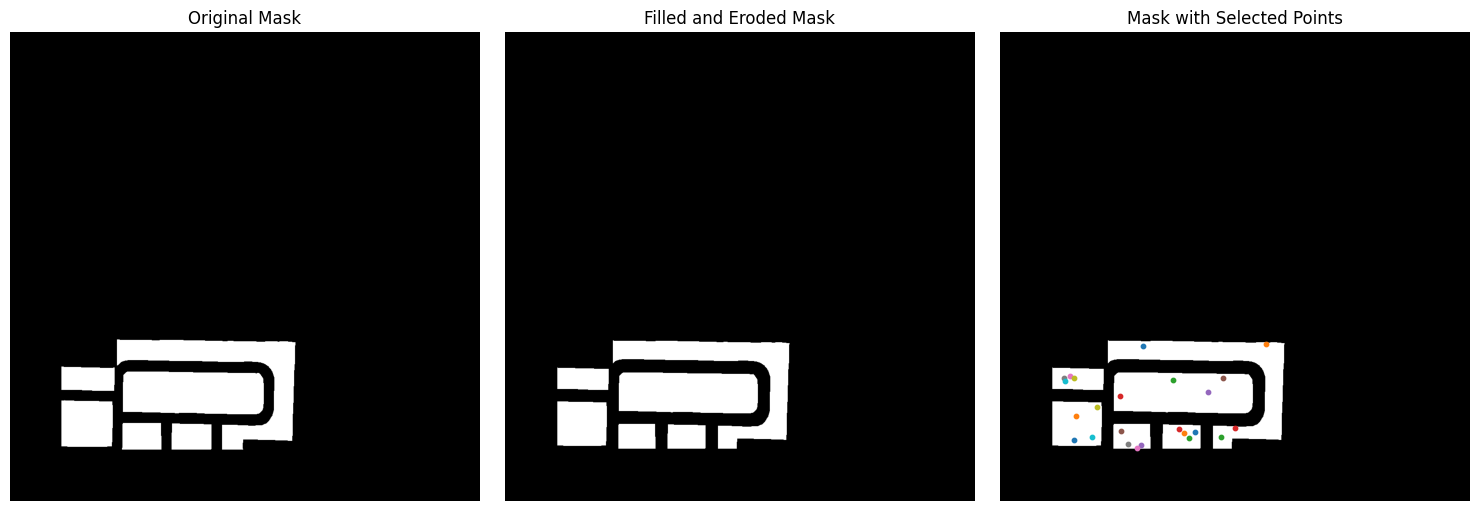

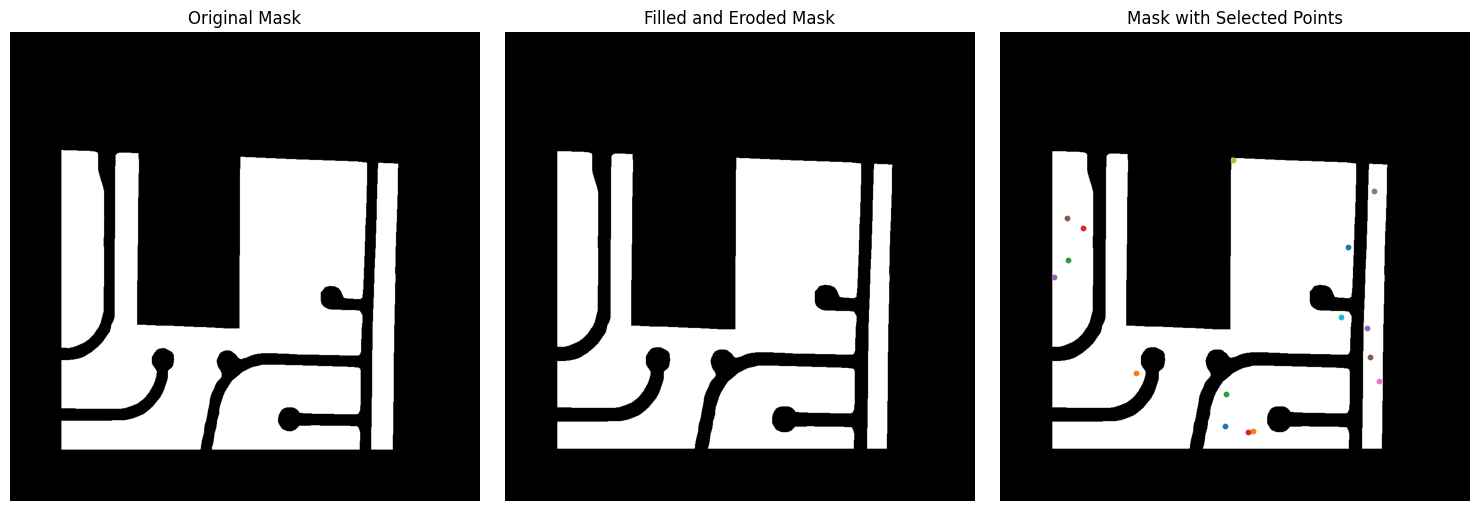

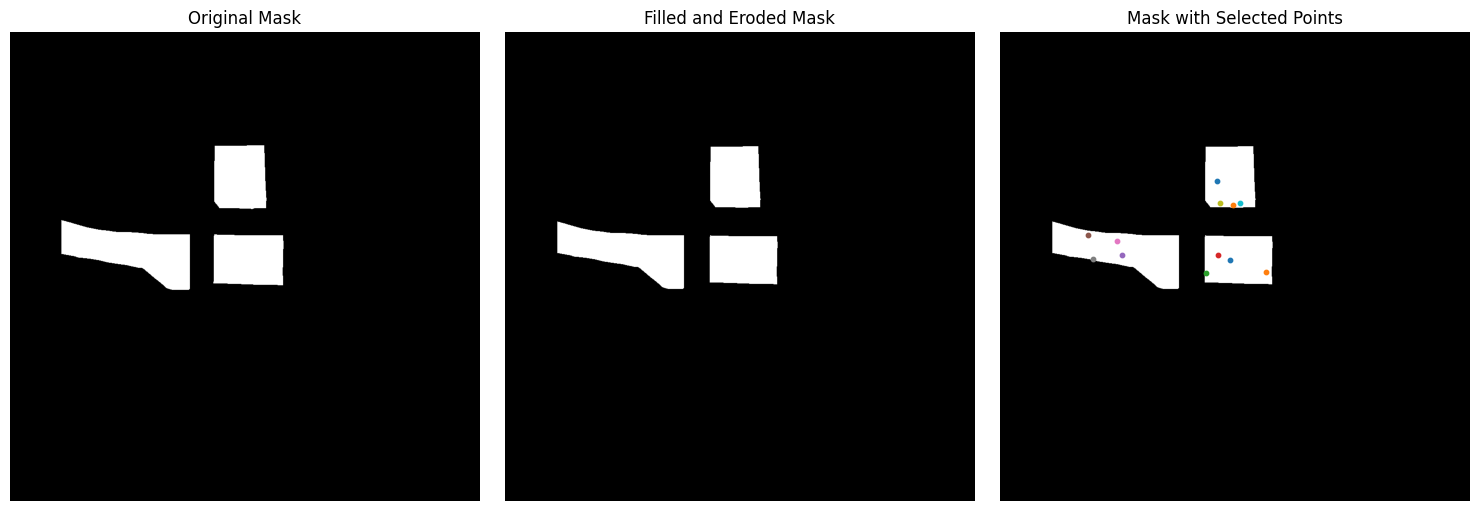

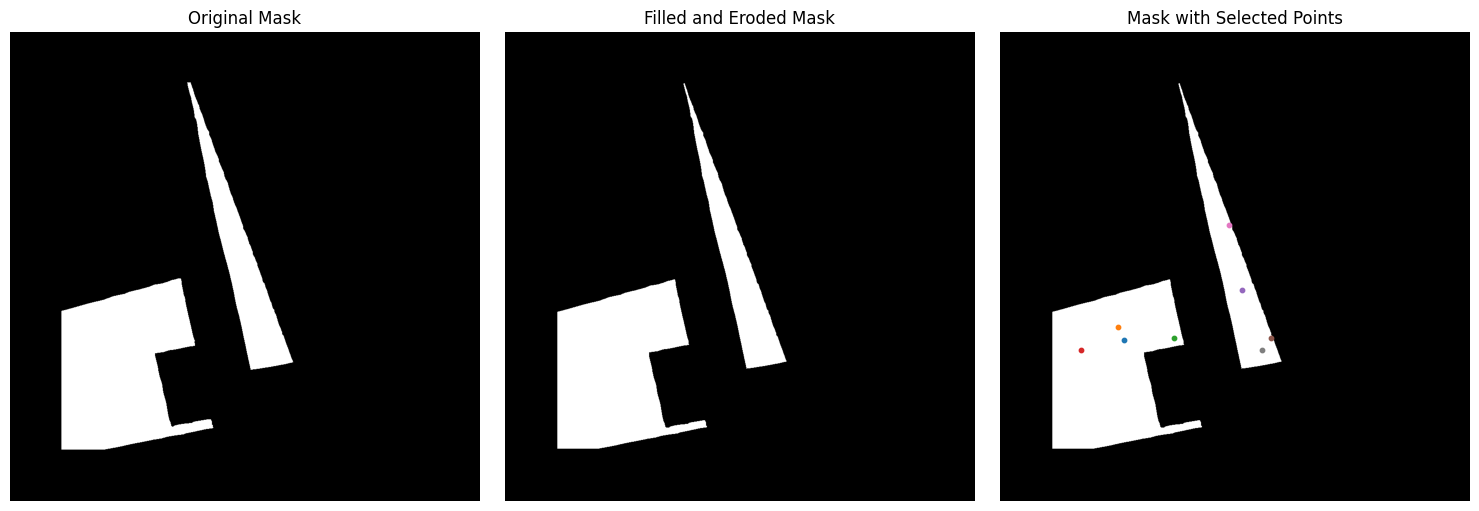

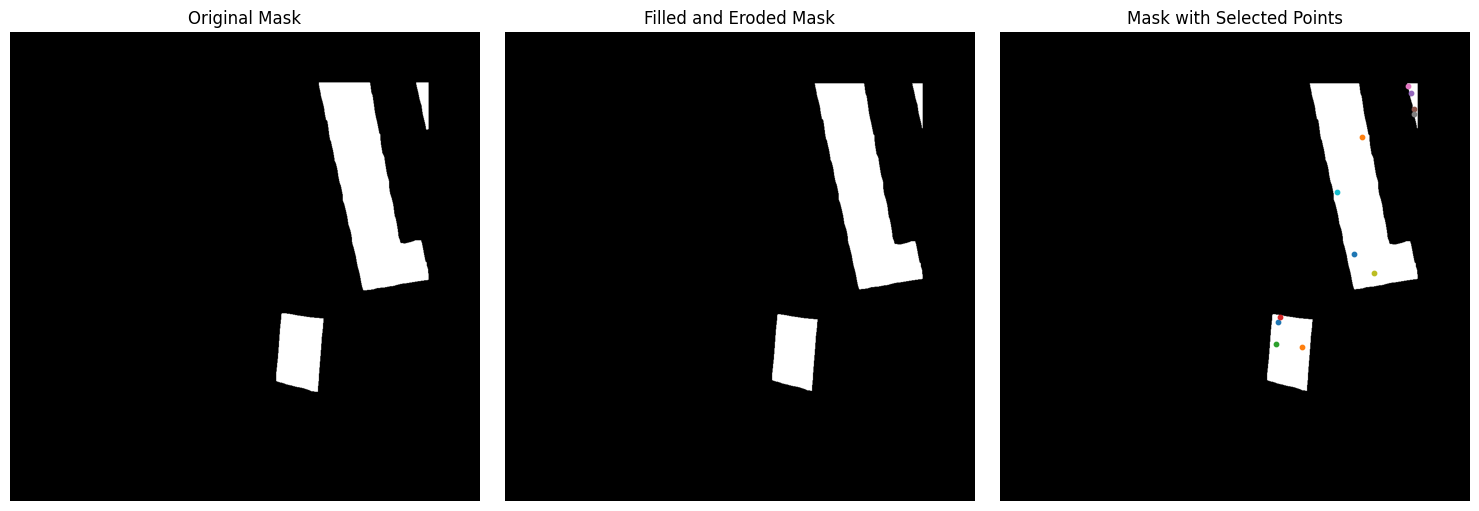

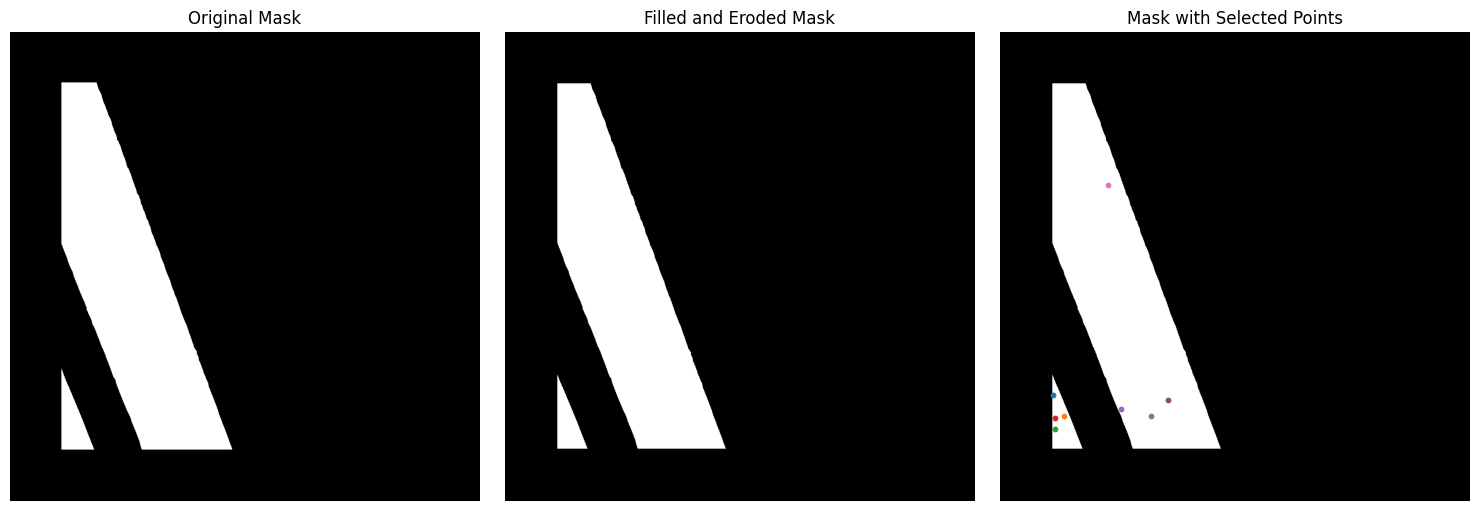

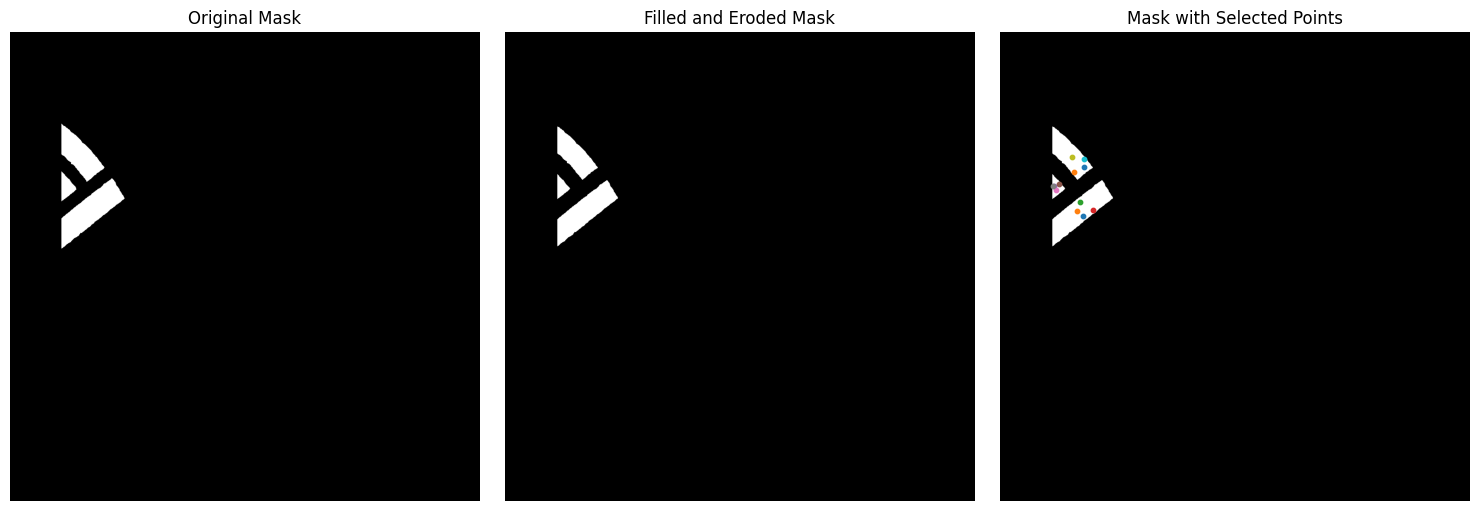

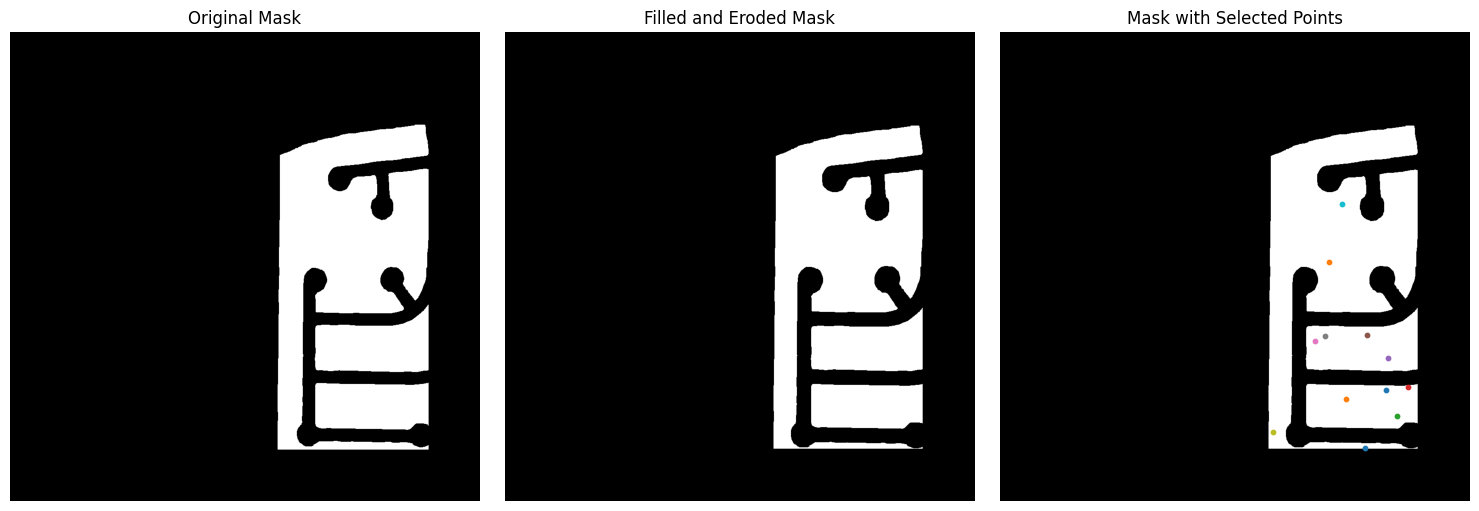

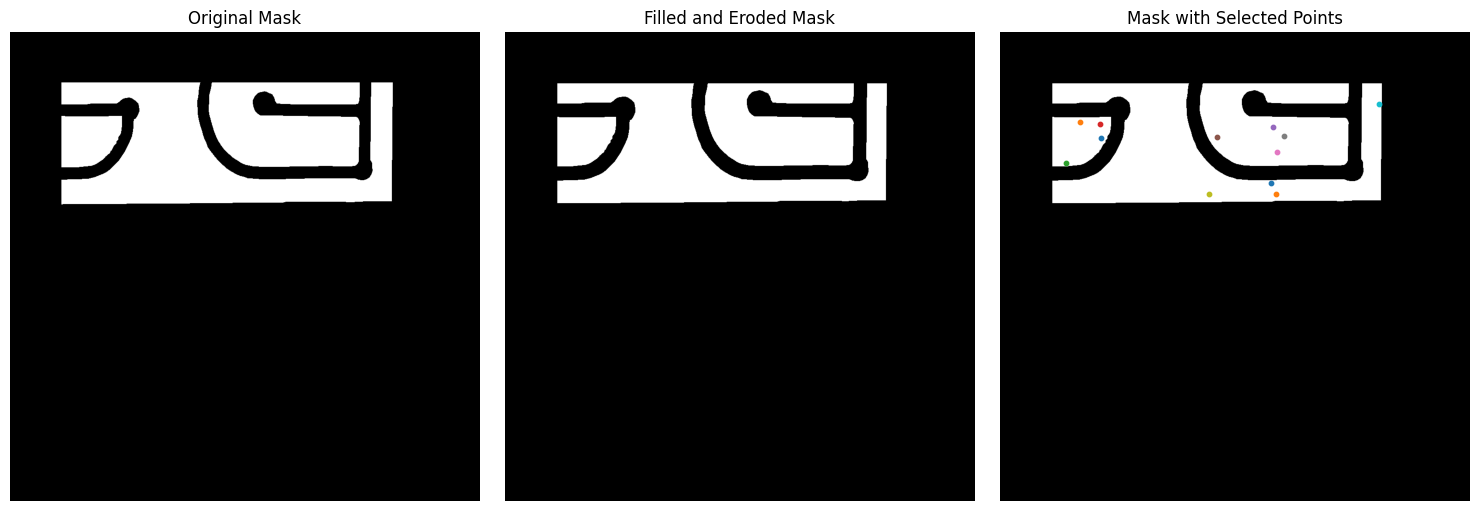

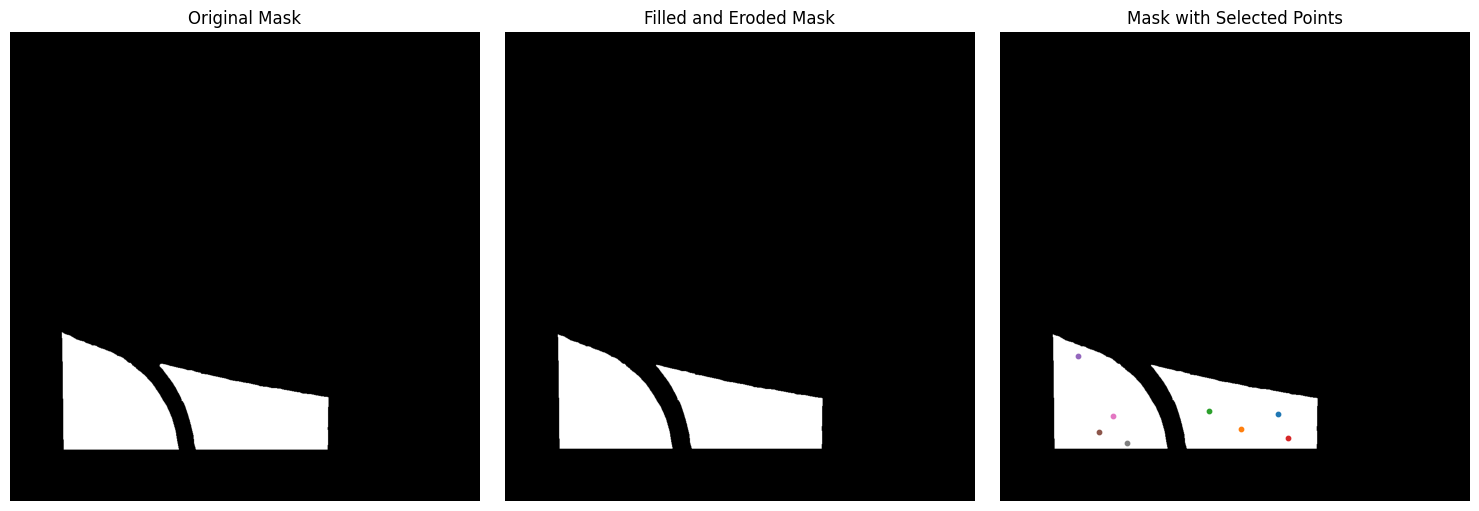

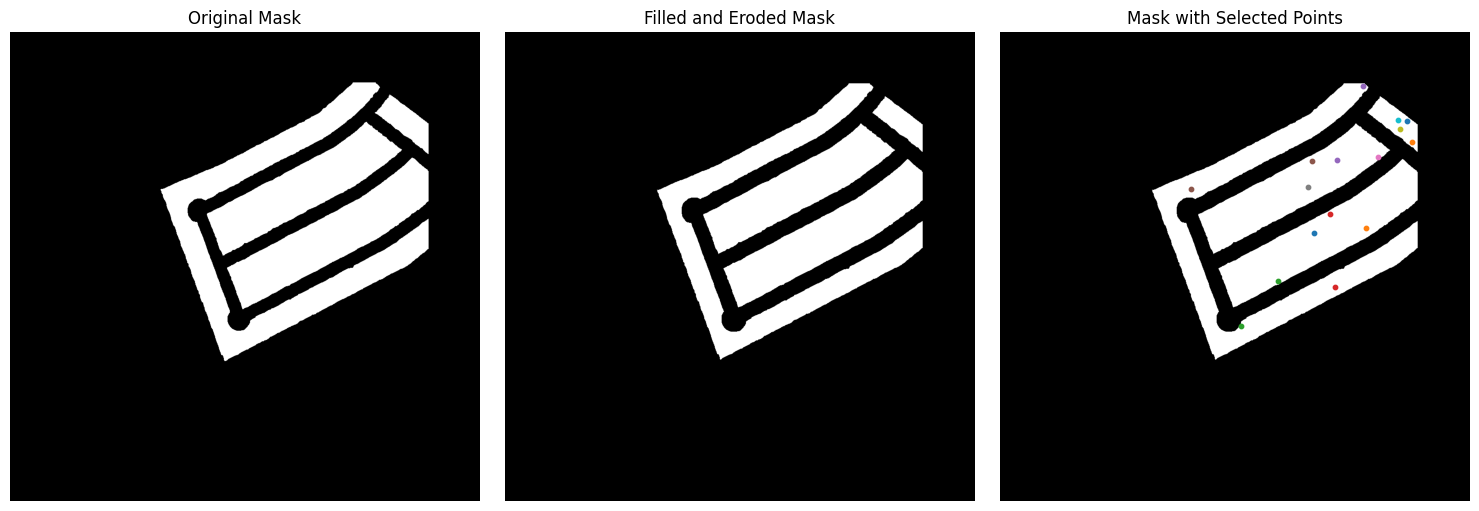

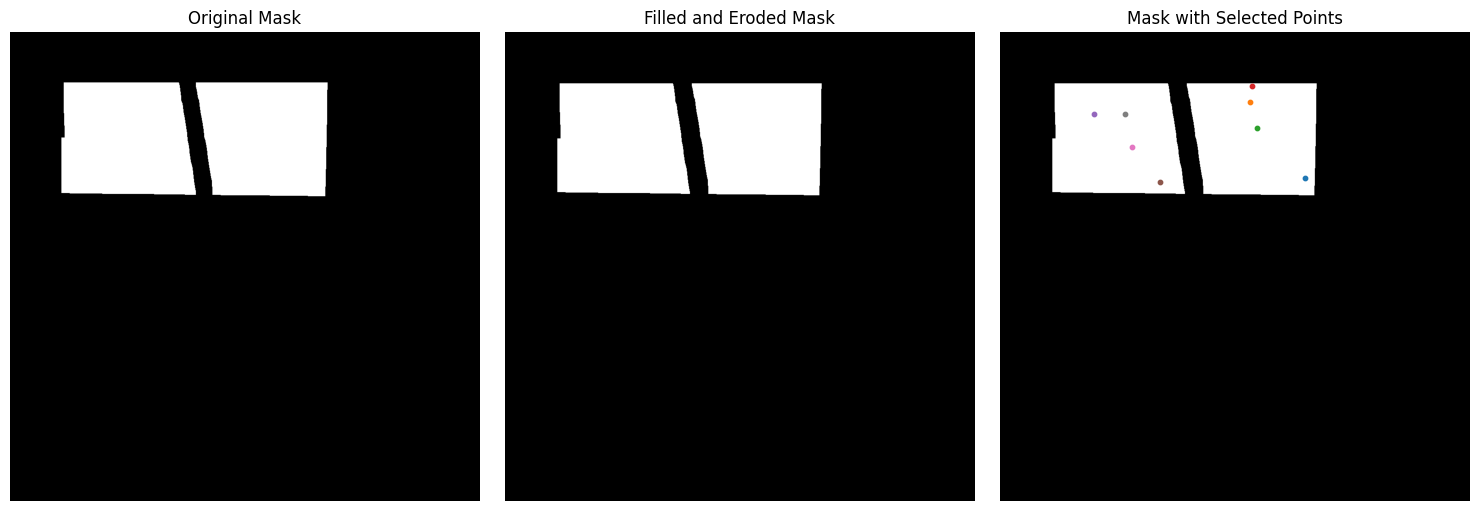

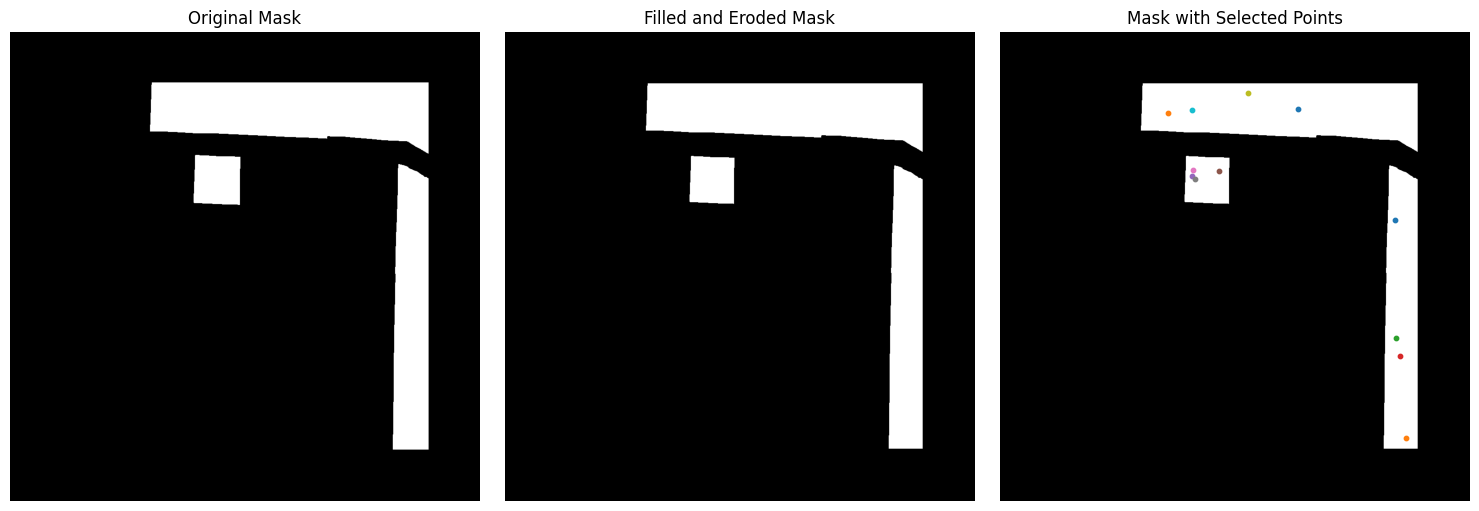

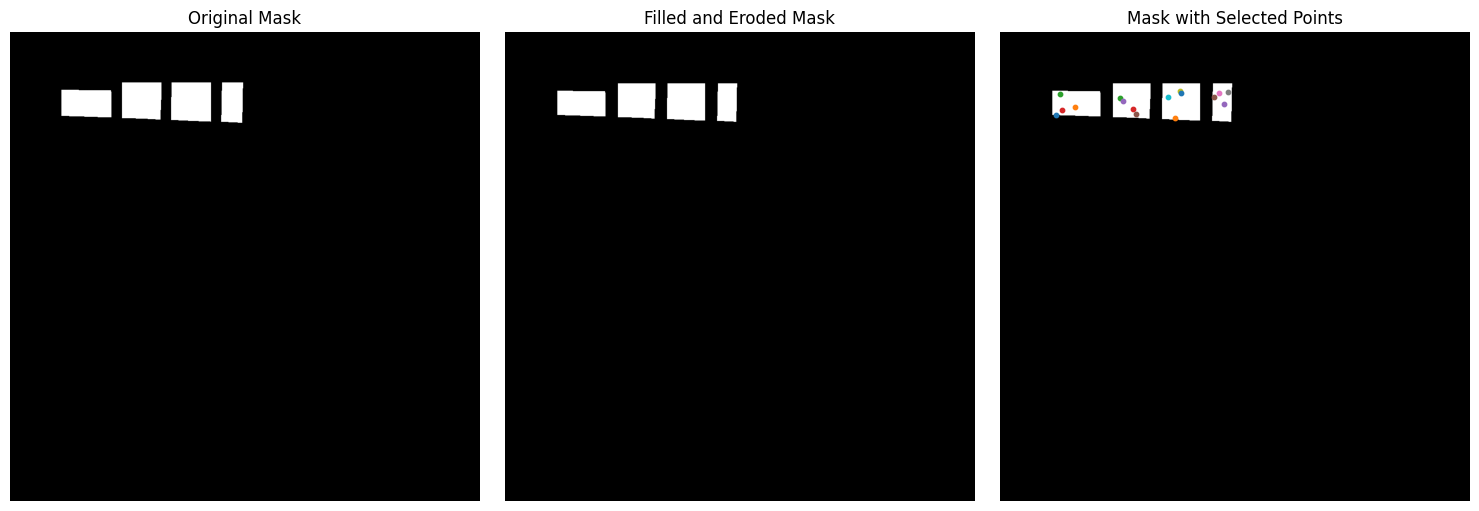

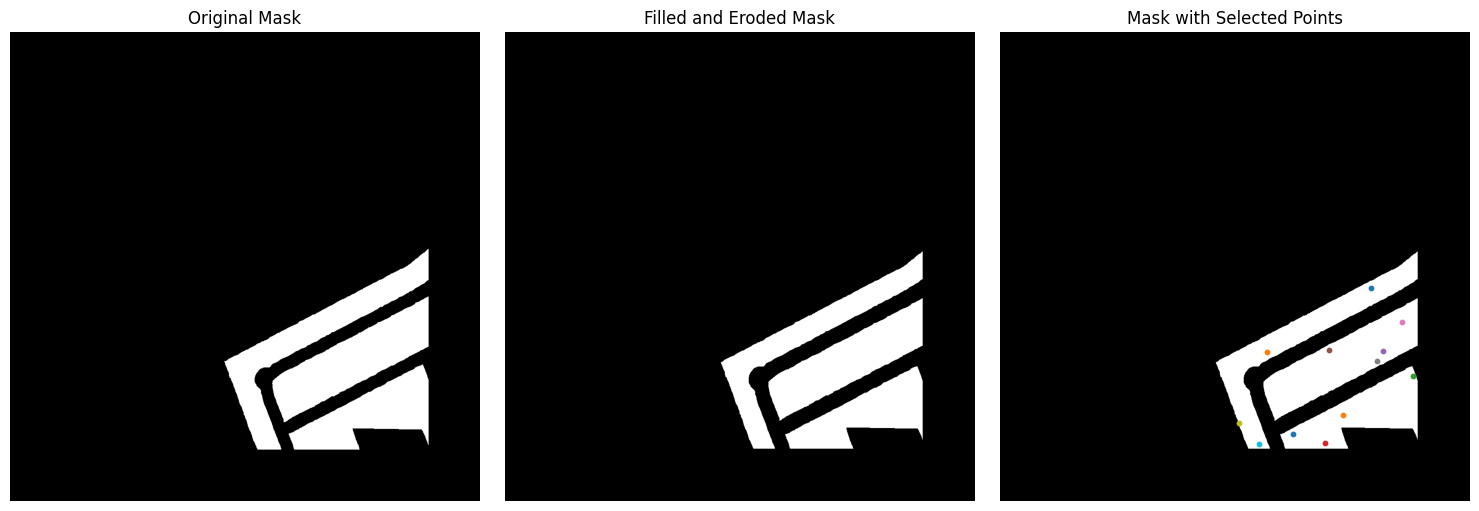

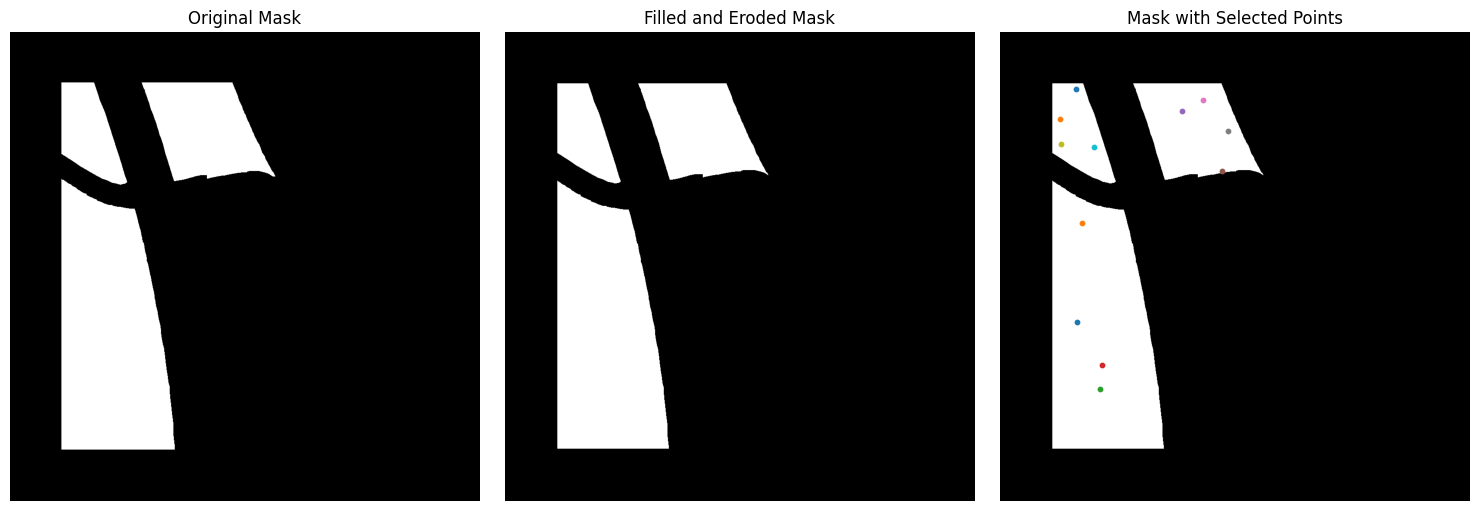

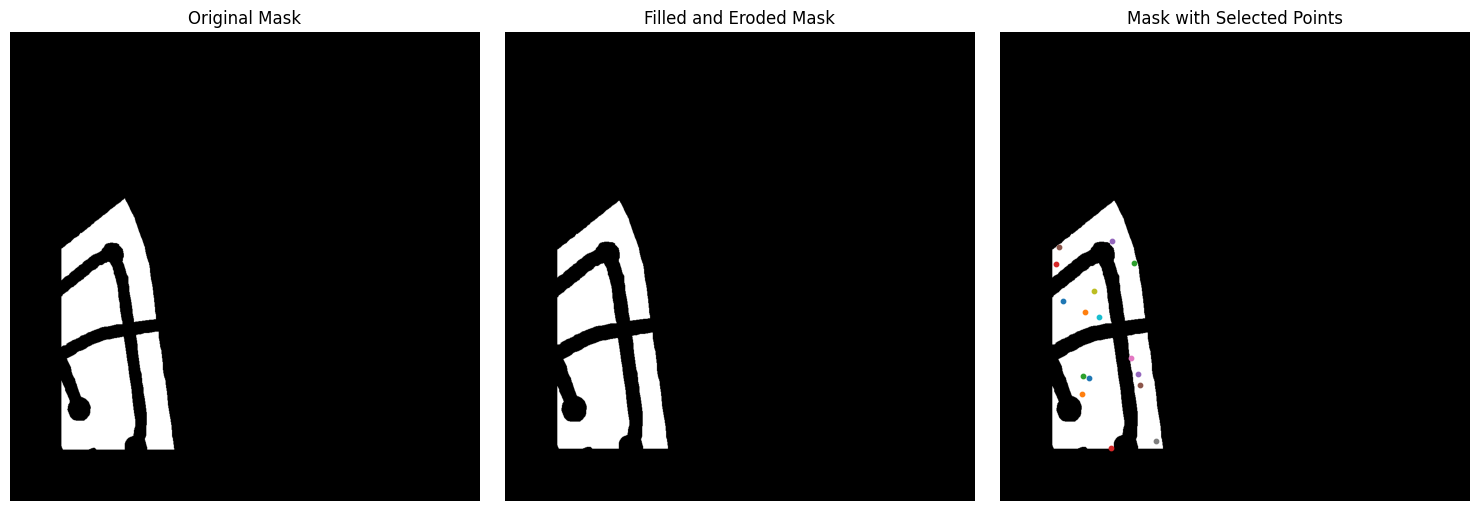

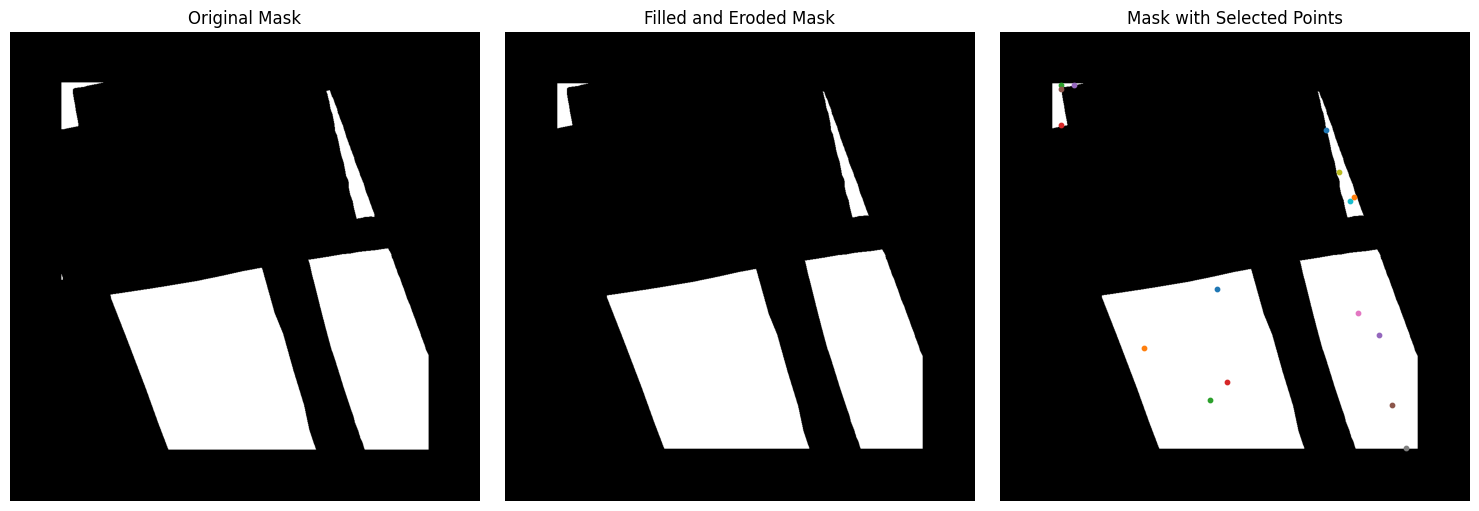

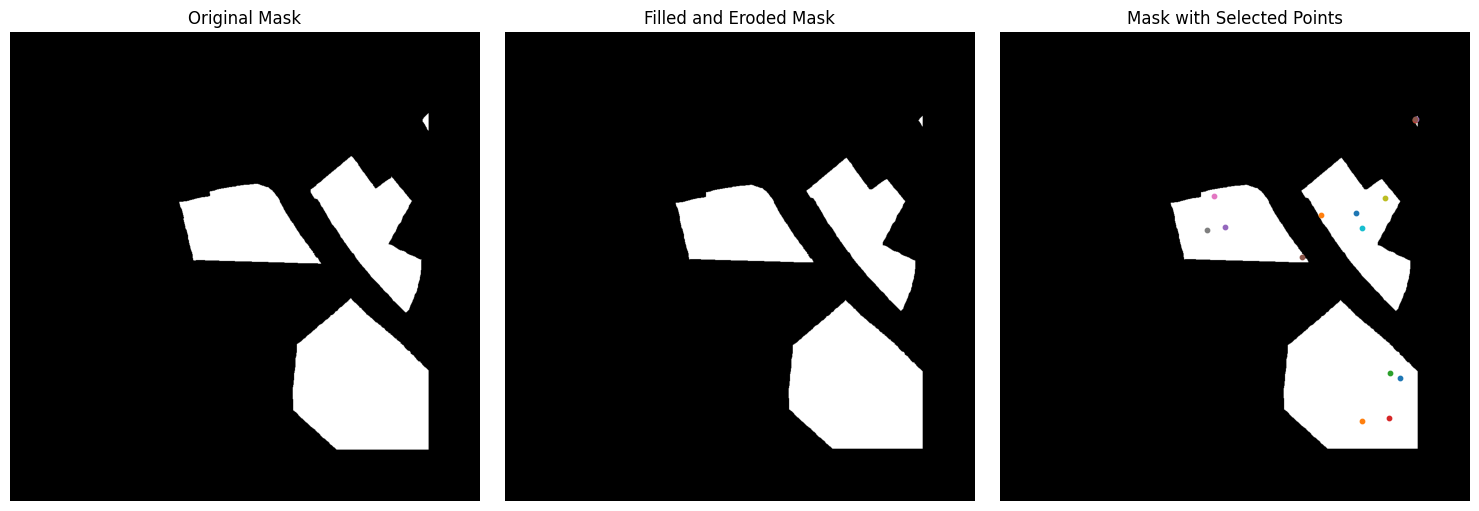

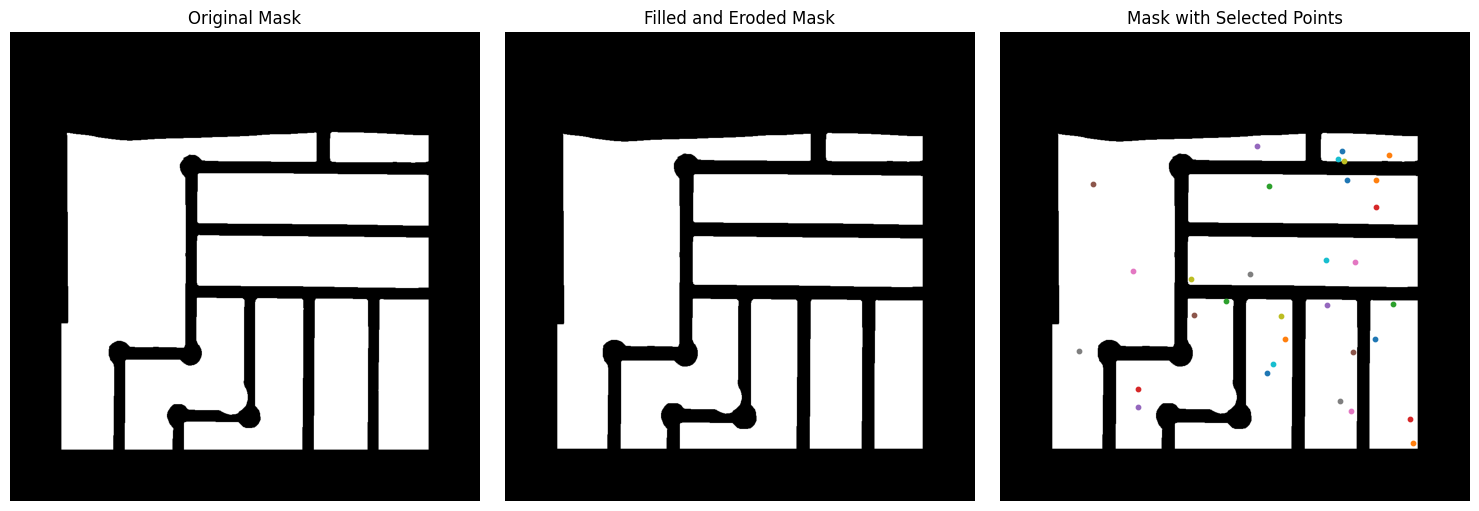

Processing complete! Output files are saved.


In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define directories
mask_images_dir = "/media/usama/SSD/Data_for_SAM2_model_Finetuning/evaluations_samples_data_for_sam2_2_jan_2025/30_samples_multiple_points_data_2_jan_2025_11/masks/"  # Directory containing mask images
txt_output_dir = "/media/usama/SSD/Data_for_SAM2_model_Finetuning/evaluations_samples_data_for_sam2_2_jan_2025/30_samples_multiple_points_data_2_jan_2025_11/"  # Directory to save the output text files

# Ensure the output directory exists
os.makedirs(txt_output_dir, exist_ok=True)

# Iterate through all mask images
for filename in os.listdir(mask_images_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        # Read the mask image
        mask_path = os.path.join(mask_images_dir, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Binarize the mask
        _, mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)

        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a new mask to draw filled contours
        filled_mask = np.zeros_like(mask)

        # # # Fill each contour
        # for contour in contours:
        #     cv2.drawContours(filled_mask, [contour], -1, 255, thickness=cv2.FILLED)

        # Apply erosion to ensure points are inside the contours
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        # eroded_mask = cv2.erode(filled_mask, kernel, iterations=5)
        eroded_mask = cv2.erode(mask,kernel,(5,5))

        # Find contours again on the eroded mask
        contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Prepare to store selected points for each contour
        all_selected_points = []

    

        for contour in contours:
            # Calculate the bounding rectangle of the contour
            x, y, w, h = cv2.boundingRect(contour)
            
            # Filter points inside the bounding rectangle but within the contour
            contour_points = [
                (px, py)
                for px in range(x + 1, x + w - 1)  # Exclude the boundary by skipping edges
                for py in range(y + 1, y + h - 1)
                if cv2.pointPolygonTest(contour, (px, py), False) > 0  # Check if inside the contour
            ]
            
            # Randomly select 4 unique points from the filtered points
            if len(contour_points) >= 4:
                selected_indices = np.random.choice(len(contour_points), 4, replace=False)
                selected_points = [contour_points[i] for i in selected_indices]
            else:
                selected_points = contour_points

            # Add the selected points for the current contour
            all_selected_points.extend(selected_points)

        # Write the selected points for all contours to a text file
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(txt_output_dir, txt_filename)

        with open(txt_path, 'w') as txt_file:
            for point in all_selected_points:
                txt_file.write(f"{point[0]},{point[1]}\n")

        # Visualization
        plt.figure(figsize=(15, 5))

        # Original Mask
        plt.subplot(1, 3, 1)
        plt.title('Original Mask')
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        # Filled and Eroded Mask
        plt.subplot(1, 3, 2)
        plt.title('Filled and Eroded Mask')
        plt.imshow(eroded_mask, cmap='gray')
        plt.axis('off')

        # Mask with Selected Points
        plt.subplot(1, 3, 3)
        plt.title('Mask with Selected Points')
        plt.imshow(eroded_mask, cmap='gray')

        for i, point in enumerate(all_selected_points):
            plt.scatter(point[0], point[1], s=10, label=f'Point {i+1}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

print("Processing complete! Output files are saved.")
